In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
os.chdir(r"C:\Users\kaborg15\Python_projects\Vibrent_Style_Quiz_Generation")

import pandas as pd
from resources.constants import *
from src import load_dataframes

OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_df.pkl"
REPRESENTATION_COLUMN = "outfit_embeddings"

pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)

embeddings_df = pd.read_pickle(OUTFIT_EMBEDDINGS_DF_PATH)

In [2]:
embeddings_df.head(2)

,group,id,name,description,owner,timeCreated,retailPrice,meta.validTo,outfit_tags,tag_categories,...,picture_ids,num_pictures,lead_embedding,lead_picture_id,num_positive_examples,filtered_tags,filtered_categories,one_hot_encoded,concatenated_embeddings,outfit_embeddings
0,group.00064a241ade73e6a5a7ad36327e4e83,outfit.d138f31106ac442f9b2e0fe163597405,New Justine Coat,"The Justine Coat features a high neck, a hidde...",user.3b5555d48f6b473f8e58956aadc0e21f,2021-10-01 10:48:04.675,3500.0000,9999-01-01 00:00:00,"[Synthetic, Multi Season, Everyday, Day Birger...","[Material, Seasons, Occasion, Brand, Size, Col...",...,[picture.7040fcb864074b28bae3c09f66972ed0],1,"[0.007065, -0.04868, -0.05066, 0.1659, 1.448, ...",picture.7040fcb864074b28bae3c09f66972ed0,186,"[Synthetic, Multi Season, Everyday, Day Birger...","[Material, Seasons, Occasion, Brand, Color, Ge...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12740439176559448, 0.11191237717866898, 0.4..."
1,group.000957e12deba05e437a5e9726e8002c,outfit.93826cc51216dcd0,Sophisticated Dress,This dress is perfect for a summer night out w...,user.15bee69d2f1541d785eee3f047ec5cf9,2017-05-08 13:28:30.000,10000.0000,9999-01-01 00:00:00,"[Fall, Dresses, XS, Prada, Grey, Women, Business]","[Seasons, Category, Size, Brand, Color, Gender...",...,"[picture.bdfc85951b9babcf, picture.b80df15a205...",6,"[-0.0823, -0.131, 0.2832, -0.1334, -0.08594, -...",picture.bdfc85951b9babcf,1716,"[Fall, Grey, Women, Business]","[Seasons, Color, Gender, Occasion]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7615255117416382, 0.6740720868110657, 0.999..."


In [4]:
# Define a distance function
from scipy.spatial.distance import cosine, euclidean
import numpy as np
from tqdm import tqdm

def calculate_mean_distance_to_all_outfits(anchor_point, embeddings, disable_progress_bar=True, leave=False):
    distances = []
    for outfit in tqdm(embeddings, disable=disable_progress_bar, leave=leave):
        distances.append(euclidean(anchor_point, outfit))
    return sum(distances) / len(distances)

embeddings = np.stack(embeddings_df[REPRESENTATION_COLUMN].values)
mean_embedding = embeddings.mean(axis=0)

mean_distance = calculate_mean_distance_to_all_outfits(mean_embedding, embeddings, disable_progress_bar=False)
mean_distance

3.5953948650878074

In [6]:
# test_embeddings = embeddings[np.random.choice(embeddings.shape[0], 10, replace=False)]
# for test_embedding in test_embeddings:
#     test_distance = calculate_mean_distance_to_all_outfits(test_embedding, embeddings, disable_progress_bar=False, leave=False)
#     print(test_distance)

In [12]:
import time
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output

from src.display_images import display_image_ids


OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_df.pkl"
REPRESENTATION_COLUMN = "outfit_embeddings"
NUM_SAMPLES_PER_CLUSTER = 27

# Note: not implemented for more than 2 clusters yet
NUM_CLUSTERS = 2

def cluster_current_split(current_cluster_df, collect_cluster_samples=True):
    outfit_representations = np.stack(current_cluster_df[REPRESENTATION_COLUMN].values)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0, n_init="auto").fit(outfit_representations)
    current_cluster_df["cluster"] = kmeans.labels_

    cluster_samples = []
    for i in range(NUM_CLUSTERS):
        cluster_outfits = current_cluster_df[current_cluster_df["cluster"] == i].copy()
        cluster_embeddings = np.stack(cluster_outfits[REPRESENTATION_COLUMN].values)
        
        # Properly represent the diversity of the cluster by applying KMeans to the embeddings
        if collect_cluster_samples:
            num_cluster_samples = min(NUM_SAMPLES_PER_CLUSTER, len(cluster_outfits))
            cluster_kmeans = KMeans(n_clusters=num_cluster_samples, random_state=1, n_init="auto").fit(cluster_embeddings)
            cluster_outfits["representation_cluster"] = cluster_kmeans.labels_
            cluster_representation = cluster_outfits.groupby("representation_cluster").first().reset_index()
            cluster_samples.append(cluster_representation)
        
    return current_cluster_df, cluster_samples


CONVERGE_THRESHOLD = 30

outfits_to_lead_picture_id_dict = embeddings_df.set_index("id")["lead_picture_id"].to_dict()
recursive_cluster_list = [embeddings_df.dropna().copy()]

run_num = 0
converged_cluster_embeddings = []
while len(recursive_cluster_list) > 0:
    recursive_cluster_df = recursive_cluster_list.pop(0)
    current_cluster_df, _ = cluster_current_split(recursive_cluster_df, collect_cluster_samples=False)

    clear_output(wait=True)
    for cluster_num in range(NUM_CLUSTERS):
        cluster_i_df = current_cluster_df[current_cluster_df["cluster"] == cluster_num].copy()
        cluster_i_df = cluster_i_df.drop(columns=["cluster"])

        if len(cluster_i_df) < CONVERGE_THRESHOLD:
            converged_cluster_embeddings.append(cluster_i_df)
            print(f"Cluster {run_num}.{cluster_num} has converged")
            continue

        #print(f"Cluster {run_num}.{cluster_num} has {len(cluster_i_df)} outfits")
        recursive_cluster_list.append(cluster_i_df)

    print(f"Run {run_num} completed, {len(recursive_cluster_list)} clusters left")
    run_num += 1



Cluster 467.0 has converged
Cluster 467.1 has converged
Run 467 completed, 0 clusters left


In [51]:
from tqdm.notebook import tqdm

converged_embeddings_list = []
for converged_df in tqdm(converged_cluster_embeddings):
    df_embeddings = np.stack(converged_df[REPRESENTATION_COLUMN].values)
    mean_embedding = df_embeddings.mean(axis=0)
    converged_embeddings_list.append(mean_embedding)

  0%|          | 0/469 [00:00<?, ?it/s]

In [16]:
for embedding in converged_embeddings_list:
    mean_distance = calculate_mean_distance_to_all_outfits(embedding, embeddings, disable_progress_bar=False, leave=False)
    print(mean_distance)

  0%|          | 0/9791 [00:00<?, ?it/s]

4.08183690311475


  0%|          | 0/9791 [00:00<?, ?it/s]

4.308393136627009


  0%|          | 0/9791 [00:00<?, ?it/s]

4.881459476031389


  0%|          | 0/9791 [00:00<?, ?it/s]

4.767502792085131


  0%|          | 0/9791 [00:00<?, ?it/s]

4.650884820805792


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3375235699290045


  0%|          | 0/9791 [00:00<?, ?it/s]

4.676046473752739


  0%|          | 0/9791 [00:00<?, ?it/s]

4.296218792099359


  0%|          | 0/9791 [00:00<?, ?it/s]

5.13099006974522


  0%|          | 0/9791 [00:00<?, ?it/s]

4.701860378247226


  0%|          | 0/9791 [00:00<?, ?it/s]

4.689297587661755


  0%|          | 0/9791 [00:00<?, ?it/s]

4.403909969265779


  0%|          | 0/9791 [00:00<?, ?it/s]

4.217615452980777


  0%|          | 0/9791 [00:00<?, ?it/s]

5.146836116673683


  0%|          | 0/9791 [00:00<?, ?it/s]

4.231798997086486


  0%|          | 0/9791 [00:00<?, ?it/s]

3.9933055047082426


  0%|          | 0/9791 [00:00<?, ?it/s]

4.229735307799383


  0%|          | 0/9791 [00:00<?, ?it/s]

4.300718170571548


  0%|          | 0/9791 [00:00<?, ?it/s]

4.195325173373889


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2801238934337995


  0%|          | 0/9791 [00:00<?, ?it/s]

4.923611284768414


  0%|          | 0/9791 [00:00<?, ?it/s]

5.875770977558778


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5653380133093675


  0%|          | 0/9791 [00:00<?, ?it/s]

4.402684854340193


  0%|          | 0/9791 [00:00<?, ?it/s]

4.219404547190292


  0%|          | 0/9791 [00:00<?, ?it/s]

4.562300254183465


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4185696306606195


  0%|          | 0/9791 [00:00<?, ?it/s]

4.46437173512524


  0%|          | 0/9791 [00:00<?, ?it/s]

4.413739881975512


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2908368674100235


  0%|          | 0/9791 [00:00<?, ?it/s]

4.315898176964625


  0%|          | 0/9791 [00:00<?, ?it/s]

4.373309762109302


  0%|          | 0/9791 [00:00<?, ?it/s]

4.504560502547483


  0%|          | 0/9791 [00:00<?, ?it/s]

4.322415661277456


  0%|          | 0/9791 [00:00<?, ?it/s]

4.709481152700149


  0%|          | 0/9791 [00:00<?, ?it/s]

4.620056777064718


  0%|          | 0/9791 [00:00<?, ?it/s]

4.813614223037569


  0%|          | 0/9791 [00:00<?, ?it/s]

4.811055350350204


  0%|          | 0/9791 [00:00<?, ?it/s]

4.832680162844302


  0%|          | 0/9791 [00:00<?, ?it/s]

4.73703068622217


  0%|          | 0/9791 [00:00<?, ?it/s]

4.663066334513551


  0%|          | 0/9791 [00:00<?, ?it/s]

4.740729540314371


  0%|          | 0/9791 [00:00<?, ?it/s]

4.776424150105532


  0%|          | 0/9791 [00:00<?, ?it/s]

4.710595845459277


  0%|          | 0/9791 [00:00<?, ?it/s]

4.234144397663372


  0%|          | 0/9791 [00:00<?, ?it/s]

4.924379879673478


  0%|          | 0/9791 [00:00<?, ?it/s]

5.3897925429053535


  0%|          | 0/9791 [00:00<?, ?it/s]

4.752505834806256


  0%|          | 0/9791 [00:00<?, ?it/s]

4.529847678027542


  0%|          | 0/9791 [00:00<?, ?it/s]

4.340915688298557


  0%|          | 0/9791 [00:00<?, ?it/s]

4.361373069858039


  0%|          | 0/9791 [00:00<?, ?it/s]

4.39077452155659


  0%|          | 0/9791 [00:00<?, ?it/s]

4.331167412103713


  0%|          | 0/9791 [00:00<?, ?it/s]

4.244594126066058


  0%|          | 0/9791 [00:00<?, ?it/s]

4.502967039773208


  0%|          | 0/9791 [00:00<?, ?it/s]

4.527857538504409


  0%|          | 0/9791 [00:00<?, ?it/s]

4.111289494431853


  0%|          | 0/9791 [00:00<?, ?it/s]

4.501285092450101


  0%|          | 0/9791 [00:00<?, ?it/s]

4.530765779870023


  0%|          | 0/9791 [00:00<?, ?it/s]

4.499353063852398


  0%|          | 0/9791 [00:00<?, ?it/s]

4.418207024307842


  0%|          | 0/9791 [00:00<?, ?it/s]

4.354352549311152


  0%|          | 0/9791 [00:00<?, ?it/s]

4.228542744269892


  0%|          | 0/9791 [00:00<?, ?it/s]

4.920471725431377


  0%|          | 0/9791 [00:00<?, ?it/s]

4.515302587822998


  0%|          | 0/9791 [00:00<?, ?it/s]

4.310352089004141


  0%|          | 0/9791 [00:00<?, ?it/s]

4.308719558374955


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1796301312885085


  0%|          | 0/9791 [00:00<?, ?it/s]

4.347399401447732


  0%|          | 0/9791 [00:00<?, ?it/s]

4.083494145853866


  0%|          | 0/9791 [00:00<?, ?it/s]

4.05084349806143


  0%|          | 0/9791 [00:00<?, ?it/s]

4.305165178134601


  0%|          | 0/9791 [00:00<?, ?it/s]

4.173460865575127


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2119825870631535


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2671726076244525


  0%|          | 0/9791 [00:00<?, ?it/s]

4.305219061729382


  0%|          | 0/9791 [00:00<?, ?it/s]

4.193221606563788


  0%|          | 0/9791 [00:00<?, ?it/s]

4.296631856029064


  0%|          | 0/9791 [00:00<?, ?it/s]

4.36049219277887


  0%|          | 0/9791 [00:00<?, ?it/s]

4.671908821997191


  0%|          | 0/9791 [00:00<?, ?it/s]

4.520285707720895


  0%|          | 0/9791 [00:00<?, ?it/s]

4.392478475997793


  0%|          | 0/9791 [00:00<?, ?it/s]

4.078432094351383


  0%|          | 0/9791 [00:00<?, ?it/s]

4.461206657321657


  0%|          | 0/9791 [00:00<?, ?it/s]

4.319513642531647


  0%|          | 0/9791 [00:00<?, ?it/s]

4.611005110215656


  0%|          | 0/9791 [00:00<?, ?it/s]

4.394019698126646


  0%|          | 0/9791 [00:00<?, ?it/s]

4.357105554179436


  0%|          | 0/9791 [00:00<?, ?it/s]

4.433917325400444


  0%|          | 0/9791 [00:00<?, ?it/s]

4.336837694425447


  0%|          | 0/9791 [00:00<?, ?it/s]

4.399906221499422


  0%|          | 0/9791 [00:00<?, ?it/s]

4.625270827583526


  0%|          | 0/9791 [00:00<?, ?it/s]

4.152644778565081


  0%|          | 0/9791 [00:00<?, ?it/s]

4.572967657592778


  0%|          | 0/9791 [00:00<?, ?it/s]

4.722632633586241


  0%|          | 0/9791 [00:00<?, ?it/s]

4.512108038384758


  0%|          | 0/9791 [00:00<?, ?it/s]

4.735137455572915


  0%|          | 0/9791 [00:00<?, ?it/s]

4.508858375834519


  0%|          | 0/9791 [00:00<?, ?it/s]

4.354120259625054


  0%|          | 0/9791 [00:00<?, ?it/s]

4.700315597853344


  0%|          | 0/9791 [00:00<?, ?it/s]

4.361032736734633


  0%|          | 0/9791 [00:00<?, ?it/s]

5.125085481218247


  0%|          | 0/9791 [00:00<?, ?it/s]

4.446556854037302


  0%|          | 0/9791 [00:00<?, ?it/s]

4.393822262145608


  0%|          | 0/9791 [00:00<?, ?it/s]

4.389270900163549


  0%|          | 0/9791 [00:00<?, ?it/s]

4.178077509809252


  0%|          | 0/9791 [00:00<?, ?it/s]

5.17261903697324


  0%|          | 0/9791 [00:00<?, ?it/s]

5.271755187074711


  0%|          | 0/9791 [00:00<?, ?it/s]

4.137405029647344


  0%|          | 0/9791 [00:00<?, ?it/s]

4.586339826752265


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3654180673731755


  0%|          | 0/9791 [00:00<?, ?it/s]

3.995460225461864


  0%|          | 0/9791 [00:00<?, ?it/s]

4.383823397347568


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4910296215139995


  0%|          | 0/9791 [00:00<?, ?it/s]

4.6251937958785785


  0%|          | 0/9791 [00:00<?, ?it/s]

4.34826014111186


  0%|          | 0/9791 [00:00<?, ?it/s]

4.291263916310944


  0%|          | 0/9791 [00:00<?, ?it/s]

4.800755068372077


  0%|          | 0/9791 [00:00<?, ?it/s]

4.583801376701741


  0%|          | 0/9791 [00:00<?, ?it/s]

4.625677152367599


  0%|          | 0/9791 [00:00<?, ?it/s]

4.33056320646708


  0%|          | 0/9791 [00:00<?, ?it/s]

4.297662986651647


  0%|          | 0/9791 [00:00<?, ?it/s]

4.898123262635442


  0%|          | 0/9791 [00:00<?, ?it/s]

4.386847017154603


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1096434214450115


  0%|          | 0/9791 [00:00<?, ?it/s]

4.157480855796656


  0%|          | 0/9791 [00:00<?, ?it/s]

4.193862916433361


  0%|          | 0/9791 [00:00<?, ?it/s]

4.896644748842621


  0%|          | 0/9791 [00:00<?, ?it/s]

4.534576731505499


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2353932459890355


  0%|          | 0/9791 [00:00<?, ?it/s]

4.135422425625794


  0%|          | 0/9791 [00:00<?, ?it/s]

4.12294396095517


  0%|          | 0/9791 [00:00<?, ?it/s]

4.094801075169532


  0%|          | 0/9791 [00:00<?, ?it/s]

5.212376855357295


  0%|          | 0/9791 [00:00<?, ?it/s]

4.685284719963214


  0%|          | 0/9791 [00:00<?, ?it/s]

4.76402865849778


  0%|          | 0/9791 [00:00<?, ?it/s]

4.750925238651474


  0%|          | 0/9791 [00:00<?, ?it/s]

4.052366354179827


  0%|          | 0/9791 [00:00<?, ?it/s]

4.561368227563208


  0%|          | 0/9791 [00:00<?, ?it/s]

4.280760615059446


  0%|          | 0/9791 [00:00<?, ?it/s]

4.454073738681366


  0%|          | 0/9791 [00:00<?, ?it/s]

4.373439344044128


  0%|          | 0/9791 [00:00<?, ?it/s]

4.43393653663119


  0%|          | 0/9791 [00:00<?, ?it/s]

4.264429834917938


  0%|          | 0/9791 [00:00<?, ?it/s]

4.242919298516443


  0%|          | 0/9791 [00:00<?, ?it/s]

4.400353169574181


  0%|          | 0/9791 [00:00<?, ?it/s]

4.474209080042904


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5661258376245994


  0%|          | 0/9791 [00:00<?, ?it/s]

4.327484920769736


  0%|          | 0/9791 [00:00<?, ?it/s]

4.234946824625076


  0%|          | 0/9791 [00:00<?, ?it/s]

3.9438700360083736


  0%|          | 0/9791 [00:00<?, ?it/s]

4.151740478852933


  0%|          | 0/9791 [00:00<?, ?it/s]

4.24959160250675


  0%|          | 0/9791 [00:00<?, ?it/s]

4.587708631840042


  0%|          | 0/9791 [00:00<?, ?it/s]

4.138326427263116


  0%|          | 0/9791 [00:00<?, ?it/s]

4.095143900383021


  0%|          | 0/9791 [00:00<?, ?it/s]

4.244525280590034


  0%|          | 0/9791 [00:00<?, ?it/s]

4.0136899519425056


  0%|          | 0/9791 [00:00<?, ?it/s]

4.675619645226133


  0%|          | 0/9791 [00:00<?, ?it/s]

4.172618106096463


  0%|          | 0/9791 [00:00<?, ?it/s]

4.228595392638996


  0%|          | 0/9791 [00:00<?, ?it/s]

4.081401500295018


  0%|          | 0/9791 [00:00<?, ?it/s]

4.130951554390542


  0%|          | 0/9791 [00:00<?, ?it/s]

4.114063859552768


  0%|          | 0/9791 [00:00<?, ?it/s]

4.19317756997692


  0%|          | 0/9791 [00:00<?, ?it/s]

4.173345895975144


  0%|          | 0/9791 [00:00<?, ?it/s]

4.176553485543158


  0%|          | 0/9791 [00:00<?, ?it/s]

4.12854000916543


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3395610266602835


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2058229637851


  0%|          | 0/9791 [00:00<?, ?it/s]

4.200729947441128


  0%|          | 0/9791 [00:00<?, ?it/s]

4.536875904254688


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5657835458714855


  0%|          | 0/9791 [00:00<?, ?it/s]

4.468342744926569


  0%|          | 0/9791 [00:00<?, ?it/s]

4.260337610161473


  0%|          | 0/9791 [00:00<?, ?it/s]

4.325570035773514


  0%|          | 0/9791 [00:00<?, ?it/s]

4.216638649290951


  0%|          | 0/9791 [00:00<?, ?it/s]

4.343472272562718


  0%|          | 0/9791 [00:00<?, ?it/s]

4.259967496766606


  0%|          | 0/9791 [00:00<?, ?it/s]

4.380078300208049


  0%|          | 0/9791 [00:00<?, ?it/s]

4.240459309197938


  0%|          | 0/9791 [00:00<?, ?it/s]

4.548823715032411


  0%|          | 0/9791 [00:00<?, ?it/s]

4.313460523445856


  0%|          | 0/9791 [00:00<?, ?it/s]

4.485686048092622


  0%|          | 0/9791 [00:00<?, ?it/s]

4.377838579589417


  0%|          | 0/9791 [00:00<?, ?it/s]

4.734030332318607


  0%|          | 0/9791 [00:00<?, ?it/s]

4.835239426750009


  0%|          | 0/9791 [00:00<?, ?it/s]

4.282104235926924


  0%|          | 0/9791 [00:00<?, ?it/s]

4.333243615380752


  0%|          | 0/9791 [00:00<?, ?it/s]

4.606404145954657


  0%|          | 0/9791 [00:00<?, ?it/s]

4.21277366102985


  0%|          | 0/9791 [00:00<?, ?it/s]

5.016694209305397


  0%|          | 0/9791 [00:00<?, ?it/s]

4.508456782593372


  0%|          | 0/9791 [00:00<?, ?it/s]

4.461021741613351


  0%|          | 0/9791 [00:00<?, ?it/s]

4.413129138539467


  0%|          | 0/9791 [00:00<?, ?it/s]

4.057030078308809


  0%|          | 0/9791 [00:00<?, ?it/s]

4.279324629492435


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2859446814066


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2440273763002505


  0%|          | 0/9791 [00:00<?, ?it/s]

4.402590821545415


  0%|          | 0/9791 [00:00<?, ?it/s]

4.136266153597325


  0%|          | 0/9791 [00:00<?, ?it/s]

4.188233878174587


  0%|          | 0/9791 [00:00<?, ?it/s]

4.175121403377035


  0%|          | 0/9791 [00:00<?, ?it/s]

4.26234853087193


  0%|          | 0/9791 [00:00<?, ?it/s]

4.299848085989713


  0%|          | 0/9791 [00:00<?, ?it/s]

4.262911346461647


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1182454796094135


  0%|          | 0/9791 [00:00<?, ?it/s]

4.257498253267058


  0%|          | 0/9791 [00:00<?, ?it/s]

3.9980028943204857


  0%|          | 0/9791 [00:00<?, ?it/s]

4.083138027018688


  0%|          | 0/9791 [00:00<?, ?it/s]

4.183459955343997


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2422496997711185


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4504274668702575


  0%|          | 0/9791 [00:00<?, ?it/s]

4.445144287439857


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3204928201783055


  0%|          | 0/9791 [00:00<?, ?it/s]

4.302378249305898


  0%|          | 0/9791 [00:00<?, ?it/s]

4.102961759274989


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2306293596581135


  0%|          | 0/9791 [00:00<?, ?it/s]

4.202830606536687


  0%|          | 0/9791 [00:00<?, ?it/s]

4.496127319771967


  0%|          | 0/9791 [00:00<?, ?it/s]

4.179434823249082


  0%|          | 0/9791 [00:00<?, ?it/s]

4.024714216374883


  0%|          | 0/9791 [00:00<?, ?it/s]

4.261527306078488


  0%|          | 0/9791 [00:00<?, ?it/s]

4.236487557753247


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5448597845955465


  0%|          | 0/9791 [00:00<?, ?it/s]

4.646026217814231


  0%|          | 0/9791 [00:00<?, ?it/s]

4.50148444451556


  0%|          | 0/9791 [00:00<?, ?it/s]

4.657905722692436


  0%|          | 0/9791 [00:00<?, ?it/s]

4.6883971517105305


  0%|          | 0/9791 [00:00<?, ?it/s]

4.363916073932268


  0%|          | 0/9791 [00:00<?, ?it/s]

4.690208257183067


  0%|          | 0/9791 [00:00<?, ?it/s]

4.712358750063626


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3545667523054705


  0%|          | 0/9791 [00:00<?, ?it/s]

4.147421515075584


  0%|          | 0/9791 [00:00<?, ?it/s]

4.378086909473683


  0%|          | 0/9791 [00:00<?, ?it/s]

4.525465234728797


  0%|          | 0/9791 [00:00<?, ?it/s]

4.546684334451546


  0%|          | 0/9791 [00:00<?, ?it/s]

4.42311297090201


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4154480731236365


  0%|          | 0/9791 [00:00<?, ?it/s]

4.427876072172692


  0%|          | 0/9791 [00:00<?, ?it/s]

4.272902236625643


  0%|          | 0/9791 [00:00<?, ?it/s]

4.219543563228637


  0%|          | 0/9791 [00:00<?, ?it/s]

4.432261642969339


  0%|          | 0/9791 [00:00<?, ?it/s]

4.280837729488323


  0%|          | 0/9791 [00:00<?, ?it/s]

4.157084237087023


  0%|          | 0/9791 [00:00<?, ?it/s]

4.169321828700061


  0%|          | 0/9791 [00:00<?, ?it/s]

4.263864023329083


  0%|          | 0/9791 [00:00<?, ?it/s]

4.494025141594086


  0%|          | 0/9791 [00:00<?, ?it/s]

4.112279818122718


  0%|          | 0/9791 [00:00<?, ?it/s]

4.548869721045178


  0%|          | 0/9791 [00:00<?, ?it/s]

4.407587438067268


  0%|          | 0/9791 [00:00<?, ?it/s]

4.595873730363497


  0%|          | 0/9791 [00:00<?, ?it/s]

4.737020285060229


  0%|          | 0/9791 [00:00<?, ?it/s]

4.397399105815157


  0%|          | 0/9791 [00:00<?, ?it/s]

4.563204851259189


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4135982966342375


  0%|          | 0/9791 [00:00<?, ?it/s]

4.856534721816535


  0%|          | 0/9791 [00:00<?, ?it/s]

4.032002790923112


  0%|          | 0/9791 [00:00<?, ?it/s]

4.147174226345153


  0%|          | 0/9791 [00:00<?, ?it/s]

4.820241626707175


  0%|          | 0/9791 [00:00<?, ?it/s]

4.522775613284744


  0%|          | 0/9791 [00:00<?, ?it/s]

4.328020322165498


  0%|          | 0/9791 [00:00<?, ?it/s]

4.728867159738779


  0%|          | 0/9791 [00:00<?, ?it/s]

5.038101042137801


  0%|          | 0/9791 [00:00<?, ?it/s]

4.018114152846114


  0%|          | 0/9791 [00:00<?, ?it/s]

4.239784971207738


  0%|          | 0/9791 [00:00<?, ?it/s]

4.694923428220558


  0%|          | 0/9791 [00:00<?, ?it/s]

4.275120544670593


  0%|          | 0/9791 [00:00<?, ?it/s]

4.588880182532509


  0%|          | 0/9791 [00:00<?, ?it/s]

4.516741512817954


  0%|          | 0/9791 [00:00<?, ?it/s]

4.355740280552502


  0%|          | 0/9791 [00:00<?, ?it/s]

4.394722424865899


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3657082519680115


  0%|          | 0/9791 [00:00<?, ?it/s]

4.21123575971387


  0%|          | 0/9791 [00:00<?, ?it/s]

4.458814856160612


  0%|          | 0/9791 [00:00<?, ?it/s]

4.181284304016691


  0%|          | 0/9791 [00:00<?, ?it/s]

4.32509204253932


  0%|          | 0/9791 [00:00<?, ?it/s]

4.383934451152034


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4534238152451815


  0%|          | 0/9791 [00:00<?, ?it/s]

4.8382868706784645


  0%|          | 0/9791 [00:00<?, ?it/s]

4.345492328286069


  0%|          | 0/9791 [00:00<?, ?it/s]

4.856028137479417


  0%|          | 0/9791 [00:00<?, ?it/s]

4.251840498606298


  0%|          | 0/9791 [00:00<?, ?it/s]

4.185774866586635


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1809548124594


  0%|          | 0/9791 [00:00<?, ?it/s]

4.030149855721601


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2906135461389


  0%|          | 0/9791 [00:00<?, ?it/s]

4.382416261728835


  0%|          | 0/9791 [00:00<?, ?it/s]

4.121709161710095


  0%|          | 0/9791 [00:00<?, ?it/s]

4.08454169131565


  0%|          | 0/9791 [00:00<?, ?it/s]

4.603077140424939


  0%|          | 0/9791 [00:00<?, ?it/s]

4.07786681227824


  0%|          | 0/9791 [00:00<?, ?it/s]

4.098536594705494


  0%|          | 0/9791 [00:00<?, ?it/s]

4.098371504362793


  0%|          | 0/9791 [00:00<?, ?it/s]

4.303914589290996


  0%|          | 0/9791 [00:00<?, ?it/s]

4.086863419147813


  0%|          | 0/9791 [00:00<?, ?it/s]

4.300948411561246


  0%|          | 0/9791 [00:00<?, ?it/s]

4.284970182290155


  0%|          | 0/9791 [00:00<?, ?it/s]

4.06946554620434


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3266218115659845


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3508469747545595


  0%|          | 0/9791 [00:00<?, ?it/s]

4.361239411086107


  0%|          | 0/9791 [00:00<?, ?it/s]

4.166317987901954


  0%|          | 0/9791 [00:00<?, ?it/s]

4.06523972622184


  0%|          | 0/9791 [00:00<?, ?it/s]

4.0726449758418966


  0%|          | 0/9791 [00:00<?, ?it/s]

4.113535699245165


  0%|          | 0/9791 [00:00<?, ?it/s]

5.4869692370071865


  0%|          | 0/9791 [00:00<?, ?it/s]

4.296037597011569


  0%|          | 0/9791 [00:00<?, ?it/s]

4.294467469060398


  0%|          | 0/9791 [00:00<?, ?it/s]

4.161774988303338


  0%|          | 0/9791 [00:00<?, ?it/s]

4.173038068037955


  0%|          | 0/9791 [00:00<?, ?it/s]

4.374664347486992


  0%|          | 0/9791 [00:00<?, ?it/s]

4.494305606574417


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3580460034925


  0%|          | 0/9791 [00:00<?, ?it/s]

4.489090438268027


  0%|          | 0/9791 [00:00<?, ?it/s]

4.369580201545881


  0%|          | 0/9791 [00:00<?, ?it/s]

4.536403888495478


  0%|          | 0/9791 [00:00<?, ?it/s]

4.262229800172769


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4093625538127785


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3896135361771


  0%|          | 0/9791 [00:00<?, ?it/s]

4.486693405925404


  0%|          | 0/9791 [00:00<?, ?it/s]

4.535413489633844


  0%|          | 0/9791 [00:00<?, ?it/s]

4.399085404821959


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5685220431233855


  0%|          | 0/9791 [00:00<?, ?it/s]

4.475046602001123


  0%|          | 0/9791 [00:00<?, ?it/s]

4.26601831454246


  0%|          | 0/9791 [00:00<?, ?it/s]

4.031398080972785


  0%|          | 0/9791 [00:00<?, ?it/s]

4.982081934685017


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3883163774148235


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4094045120466685


  0%|          | 0/9791 [00:00<?, ?it/s]

4.299138398199572


  0%|          | 0/9791 [00:00<?, ?it/s]

4.482274803452768


  0%|          | 0/9791 [00:00<?, ?it/s]

4.59058805696752


  0%|          | 0/9791 [00:00<?, ?it/s]

4.333860860142858


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4165095233232465


  0%|          | 0/9791 [00:00<?, ?it/s]

4.455192182908588


  0%|          | 0/9791 [00:00<?, ?it/s]

4.696905163091488


  0%|          | 0/9791 [00:00<?, ?it/s]

4.373697784758811


  0%|          | 0/9791 [00:00<?, ?it/s]

4.498245659715081


  0%|          | 0/9791 [00:00<?, ?it/s]

4.321928498453856


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1706619598265355


  0%|          | 0/9791 [00:00<?, ?it/s]

4.183207397064369


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1748875303440744


  0%|          | 0/9791 [00:00<?, ?it/s]

4.282669533174282


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1381101949051375


  0%|          | 0/9791 [00:00<?, ?it/s]

4.218101194101811


  0%|          | 0/9791 [00:00<?, ?it/s]

4.241871417669535


  0%|          | 0/9791 [00:00<?, ?it/s]

4.7599379952898655


  0%|          | 0/9791 [00:00<?, ?it/s]

4.309121885031625


  0%|          | 0/9791 [00:00<?, ?it/s]

4.690574845607377


  0%|          | 0/9791 [00:00<?, ?it/s]

4.645489810217821


  0%|          | 0/9791 [00:00<?, ?it/s]

4.488215903850303


  0%|          | 0/9791 [00:00<?, ?it/s]

4.123690042563739


  0%|          | 0/9791 [00:00<?, ?it/s]

4.095905964128891


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2531862101815765


  0%|          | 0/9791 [00:00<?, ?it/s]

4.398689660694001


  0%|          | 0/9791 [00:00<?, ?it/s]

4.062210126101885


  0%|          | 0/9791 [00:00<?, ?it/s]

4.482025269504051


  0%|          | 0/9791 [00:00<?, ?it/s]

4.456518270209094


  0%|          | 0/9791 [00:00<?, ?it/s]

4.140583988108179


  0%|          | 0/9791 [00:00<?, ?it/s]

4.239752547554873


  0%|          | 0/9791 [00:00<?, ?it/s]

4.386184089520967


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2390390949176915


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2485045513319335


  0%|          | 0/9791 [00:00<?, ?it/s]

4.301062158199441


  0%|          | 0/9791 [00:00<?, ?it/s]

4.6606014368584265


  0%|          | 0/9791 [00:00<?, ?it/s]

4.137020464228074


  0%|          | 0/9791 [00:00<?, ?it/s]

4.007265570516704


  0%|          | 0/9791 [00:00<?, ?it/s]

5.092207698081581


  0%|          | 0/9791 [00:00<?, ?it/s]

4.218501395848775


  0%|          | 0/9791 [00:00<?, ?it/s]

4.324054649194356


  0%|          | 0/9791 [00:00<?, ?it/s]

4.716942340158824


  0%|          | 0/9791 [00:00<?, ?it/s]

4.519539863534124


  0%|          | 0/9791 [00:00<?, ?it/s]

5.044865589502533


  0%|          | 0/9791 [00:00<?, ?it/s]

4.976157320317359


  0%|          | 0/9791 [00:00<?, ?it/s]

4.1374042967129


  0%|          | 0/9791 [00:00<?, ?it/s]

3.927696175589932


  0%|          | 0/9791 [00:00<?, ?it/s]

4.082240408204415


  0%|          | 0/9791 [00:00<?, ?it/s]

4.190463376465877


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5912659170159085


  0%|          | 0/9791 [00:00<?, ?it/s]

4.480863254453403


  0%|          | 0/9791 [00:00<?, ?it/s]

4.150433916541113


  0%|          | 0/9791 [00:00<?, ?it/s]

4.200973268955546


  0%|          | 0/9791 [00:00<?, ?it/s]

4.541418317805848


  0%|          | 0/9791 [00:00<?, ?it/s]

4.250819553638002


  0%|          | 0/9791 [00:00<?, ?it/s]

4.576004675190142


  0%|          | 0/9791 [00:00<?, ?it/s]

4.214083878727451


  0%|          | 0/9791 [00:00<?, ?it/s]

4.819442258340412


  0%|          | 0/9791 [00:00<?, ?it/s]

4.494487967079551


  0%|          | 0/9791 [00:00<?, ?it/s]

4.077029586176063


  0%|          | 0/9791 [00:00<?, ?it/s]

4.465598802460876


  0%|          | 0/9791 [00:00<?, ?it/s]

4.729013314326443


  0%|          | 0/9791 [00:00<?, ?it/s]

4.484232627735817


  0%|          | 0/9791 [00:00<?, ?it/s]

4.391791104840683


  0%|          | 0/9791 [00:00<?, ?it/s]

4.674355090714145


  0%|          | 0/9791 [00:00<?, ?it/s]

4.163904157713363


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3513856338183


  0%|          | 0/9791 [00:00<?, ?it/s]

4.306423645301691


  0%|          | 0/9791 [00:00<?, ?it/s]

4.6535975558720155


  0%|          | 0/9791 [00:00<?, ?it/s]

4.450021235578078


  0%|          | 0/9791 [00:00<?, ?it/s]

4.188820212798362


  0%|          | 0/9791 [00:00<?, ?it/s]

4.312241331333166


  0%|          | 0/9791 [00:00<?, ?it/s]

4.773558015472867


  0%|          | 0/9791 [00:00<?, ?it/s]

4.041143979984728


  0%|          | 0/9791 [00:00<?, ?it/s]

4.379035215586439


  0%|          | 0/9791 [00:00<?, ?it/s]

4.355596627433947


  0%|          | 0/9791 [00:00<?, ?it/s]

4.426608446971982


  0%|          | 0/9791 [00:00<?, ?it/s]

3.967435077173669


  0%|          | 0/9791 [00:00<?, ?it/s]

4.5586286780765235


  0%|          | 0/9791 [00:00<?, ?it/s]

4.356299294455437


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2383851753724695


  0%|          | 0/9791 [00:00<?, ?it/s]

4.16452670836188


  0%|          | 0/9791 [00:00<?, ?it/s]

4.190304502653319


  0%|          | 0/9791 [00:00<?, ?it/s]

4.111608723073319


  0%|          | 0/9791 [00:00<?, ?it/s]

4.221999177224235


  0%|          | 0/9791 [00:00<?, ?it/s]

4.387830453991991


  0%|          | 0/9791 [00:00<?, ?it/s]

4.138162423260892


  0%|          | 0/9791 [00:00<?, ?it/s]

4.25611608772292


  0%|          | 0/9791 [00:00<?, ?it/s]

4.025283222472521


  0%|          | 0/9791 [00:00<?, ?it/s]

4.3643786677680465


  0%|          | 0/9791 [00:00<?, ?it/s]

4.369864381416989


  0%|          | 0/9791 [00:00<?, ?it/s]

4.342268529507389


  0%|          | 0/9791 [00:00<?, ?it/s]

4.50829005659592


  0%|          | 0/9791 [00:00<?, ?it/s]

4.397419810521457


  0%|          | 0/9791 [00:00<?, ?it/s]

4.428067390621882


  0%|          | 0/9791 [00:00<?, ?it/s]

4.358230057433923


  0%|          | 0/9791 [00:00<?, ?it/s]

4.088442336555166


  0%|          | 0/9791 [00:00<?, ?it/s]

4.2090828268111595


  0%|          | 0/9791 [00:00<?, ?it/s]

4.02398287764075


  0%|          | 0/9791 [00:00<?, ?it/s]

4.383369939416327


  0%|          | 0/9791 [00:00<?, ?it/s]

4.454572783746303


  0%|          | 0/9791 [00:00<?, ?it/s]

4.340209887008786


  0%|          | 0/9791 [00:00<?, ?it/s]

4.441933694686865


  0%|          | 0/9791 [00:00<?, ?it/s]

4.4456142269752235


  0%|          | 0/9791 [00:00<?, ?it/s]

4.356897522345116


  0%|          | 0/9791 [00:00<?, ?it/s]

4.252645041664832


  0%|          | 0/9791 [00:00<?, ?it/s]

4.428131840144279


  0%|          | 0/9791 [00:00<?, ?it/s]

4.090954972045554


  0%|          | 0/9791 [00:00<?, ?it/s]

4.286472280331402


  0%|          | 0/9791 [00:00<?, ?it/s]

4.193076817144332


  0%|          | 0/9791 [00:00<?, ?it/s]

4.343471102471207


  0%|          | 0/9791 [00:00<?, ?it/s]

4.384308982337087


  0%|          | 0/9791 [00:00<?, ?it/s]

4.754789155060397


  0%|          | 0/9791 [00:00<?, ?it/s]

4.889365508748248


  0%|          | 0/9791 [00:00<?, ?it/s]

4.233643212386186


  0%|          | 0/9791 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
def check_if_closer_than_existing(embedding, all_embeddings, distances_dict, excluded_index=None):
    for i, existing_embedding in enumerate(all_embeddings):
        # Functionality to exclude a specific index, used to make sure the outfit itself is not considered
        if i == excluded_index:
            continue

        distance = euclidean(embedding, existing_embedding)
        if distance < distances_dict[i]:
            distances_dict[i] = distance


# Calculate the shortest distance to a converged cluster for each outfit
all_embeddings = embeddings_df[REPRESENTATION_COLUMN].values
closest_converged_distance = {i: 100.0 for i in range(len(all_embeddings))}

for converged_embedding in tqdm(converged_embeddings_list):
    check_if_closer_than_existing(converged_embedding, all_embeddings, closest_converged_distance)
sum(closest_converged_distance.values()) / len(closest_converged_distance)

  0%|          | 0/469 [00:00<?, ?it/s]

2.564139128709281

In [63]:
from IPython.display import clear_output


all_embeddings = embeddings_df[REPRESENTATION_COLUMN].values
closest_neighbor_distance = {i: 100.0 for i in range(len(all_embeddings))}

for i, embedding in tqdm(enumerate(all_embeddings)):
    check_if_closer_than_existing(embedding, all_embeddings, closest_neighbor_distance, excluded_index=i)
    if i % 100 == 0:
        #clear_output(wait=True)
        print(f"Mean distance: {sum(closest_neighbor_distance.values()) / len(closest_neighbor_distance)}")
    
sum(closest_neighbor_distance.values()) / len(closest_neighbor_distance)

0it [00:00, ?it/s]

Mean distance: 5.09736695276102
Mean distance: 3.6318786181685807
Mean distance: 3.434610389072642
Mean distance: 3.320903475438652
Mean distance: 3.232142899008737
Mean distance: 3.1746065050991765
Mean distance: 3.1123560870937372
Mean distance: 3.0710372024641797
Mean distance: 3.03183983422846
Mean distance: 3.0024758708445316
Mean distance: 2.969399602690222
Mean distance: 2.9455878338192227
Mean distance: 2.9291602387990783
Mean distance: 2.9087743130838764
Mean distance: 2.8803933848412067
Mean distance: 2.858333207067782
Mean distance: 2.837552780160825
Mean distance: 2.8215733052113654
Mean distance: 2.8028321625374453
Mean distance: 2.7882574912589706
Mean distance: 2.7737523947331937
Mean distance: 2.7597024222986417
Mean distance: 2.7476419390862654
Mean distance: 2.7335027020846527
Mean distance: 2.720154935452802
Mean distance: 2.707647746006813
Mean distance: 2.694758728690188
Mean distance: 2.684100800424055
Mean distance: 2.672057358042328
Mean distance: 2.661783349270

2.3070259505796393

In [7]:
def category_unless_no_positive_exampels(row):
    if row["num_positive_examples"] == 0:
        return "No positive examples"
    elif len(row["category"]) == 0:
        return "No category"
    return row["category"][0]

embeddings_df["custom_category"] = embeddings_df.apply(category_unless_no_positive_exampels, axis=1)

c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


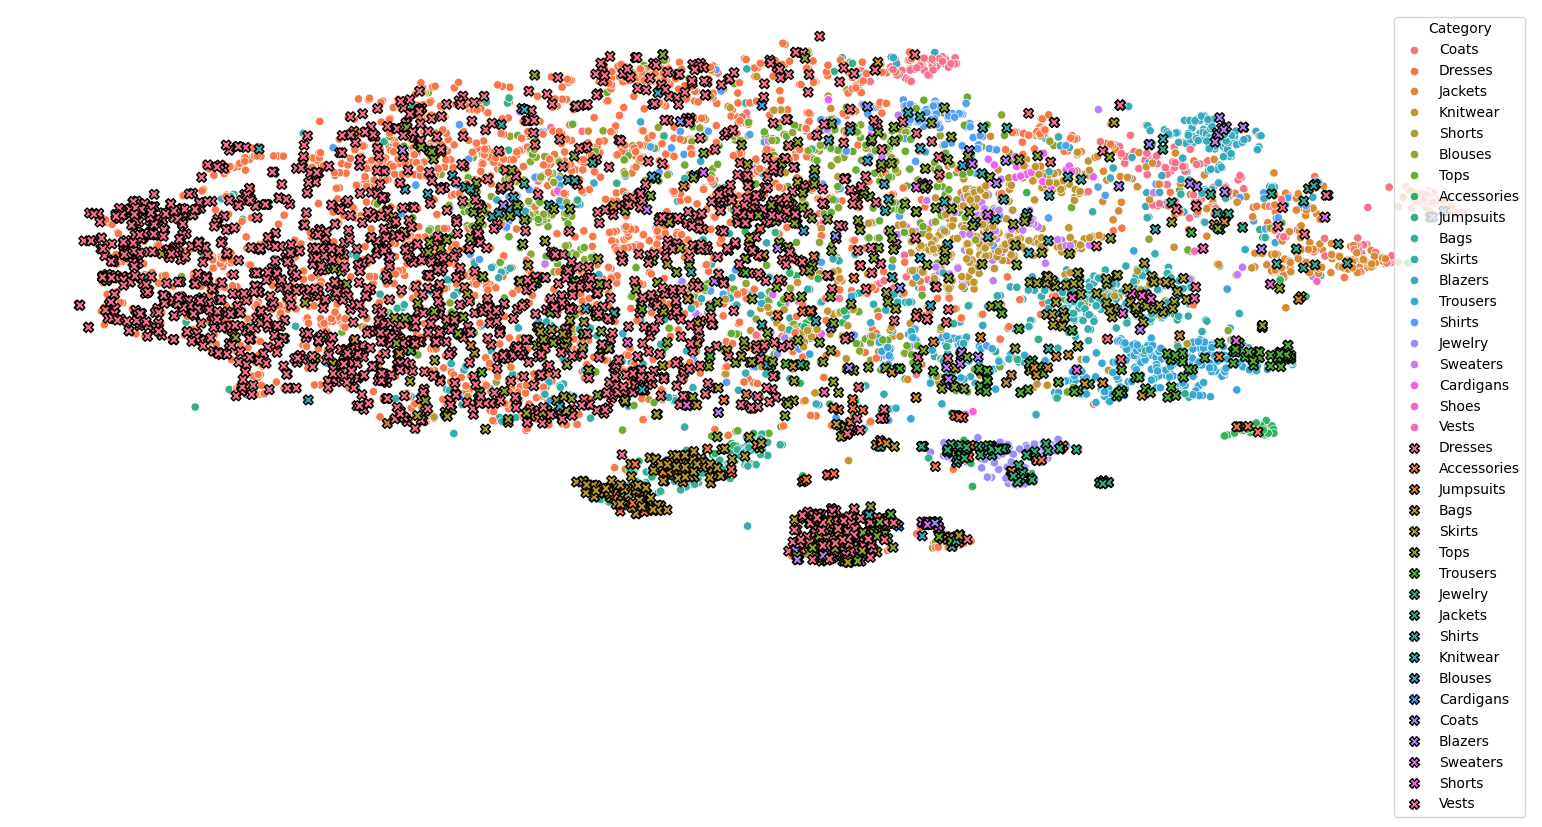

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"

#Generate TSNE diagram of embeddings, but only for outfits with at least one picture
#Save this graph to file to load it into PIL for later editing
tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(embeddings_df, "outfit_embeddings", mark_points=embeddings_df["custom_category"] == "No positive examples", show_plot=True, save_path=FIGURE_SAVE_PATH)

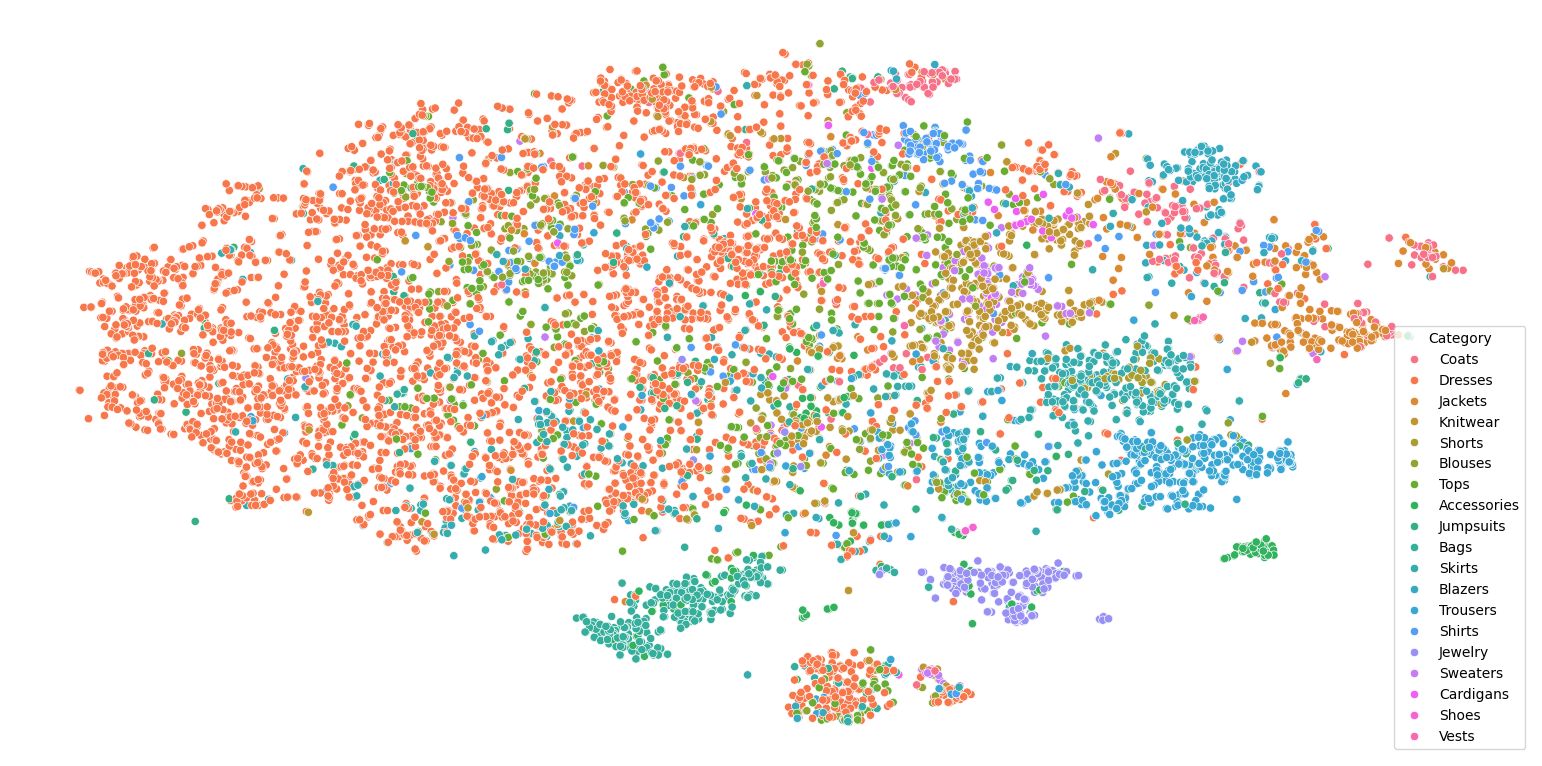

In [27]:
tsne_original_df, scatter_original_plot, tsne = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(embeddings_df, REPRESENTATION_COLUMN, show_plot=True, return_tsne=True, save_path=FIGURE_SAVE_PATH)